# 4. Lets Try Dimensionality Reduction to minimize the cost

# Dimensionality Reduction

- We will use PCA to perform dimensionality reduction.

In [34]:
train = pd.read_csv("Train_imputed_median")
test = pd.read_csv("test_imputed_median")
y_train = pd.read_csv("y_train")
y_test = pd.read_csv("y_test")

train.drop(['Unnamed: 0'],axis = 1,inplace = True)
test.drop(['Unnamed: 0'],axis = 1,inplace = True)
y_train.drop(['Unnamed: 0'],axis = 1,inplace = True)
y_test.drop(['Unnamed: 0'],axis = 1,inplace = True)

#train['class'] = y_train

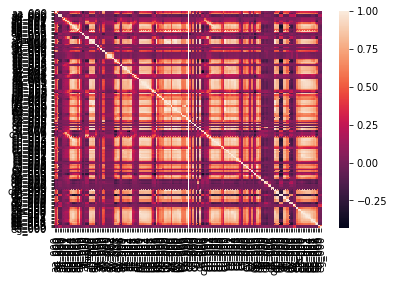

In [35]:
# Determining the correlation between features using spearman correlation and plotting the heatmap.
corelation_matrix = train.corr(method='spearman')

sns.heatmap(data = corelation_matrix,xticklabels=train.columns,yticklabels=train.columns)


In [36]:
#Performing standardization and PCA for dimensionality reduction
start = datetime.now()
std = StandardScaler()
train_std = std.fit_transform(train)
train_pca = PCA(n_components= 160,random_state=42)
train_pca.fit_transform(train_std)
print("Time required to run this cell", datetime.now() - start)

Time required to run this cell 0:00:01.586515


<function matplotlib.pyplot.show(*args, **kw)>

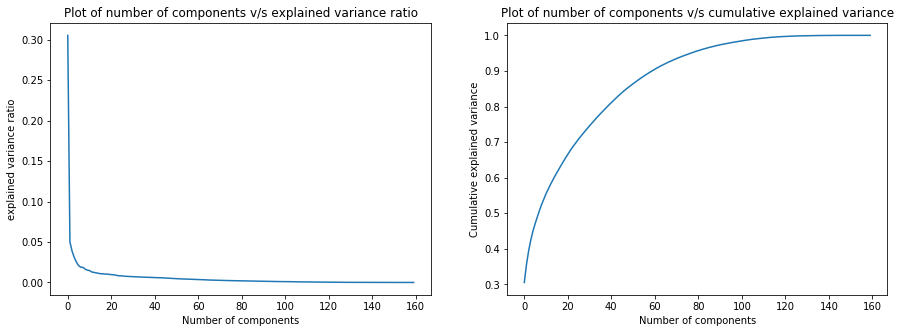

In [37]:
# Plot of number of features v/s explained variance ratio.
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(data=train_pca.explained_variance_ratio_)
plt.xlabel("Number of components")
plt.ylabel("explained variance ratio")
plt.title("Plot of number of components v/s explained variance ratio")
plt.subplot(1,2,2)
sns.lineplot(data=np.cumsum(train_pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Plot of number of components v/s cumulative explained variance")
plt.show

In [86]:
print("With Number of components as 90, the total explained variance is " ,train_pca.explained_variance_ratio_[:90].sum())

With Number of components as 90, the total explained variance is  0.9720430145910608


- With 90 features we have a explained variance of 97%. Therefore we have reduced the dimension from 160 features to 90 features.

In [39]:
pca_100 = PCA(n_components=90,random_state=42)
train_100= pca_100.fit_transform(train_std)


In [40]:
test_std = std.transform(test)
test_100 = pca_100.transform(test_std)

In [50]:
train = pd.DataFrame(train_100)
test = pd.DataFrame(test_100)
train['class'] = y_train

In [51]:
#downsampling the negative class
train_neg_sampled = train[train['class'] == 0].sample(n = 10000,random_state = 42)
train_Sampled = train[train['class'] == 1].append(train_neg_sampled)

In [52]:
print("Shape of the train data after under sampling the negative class", train_Sampled.shape[0])

Shape of the train data after under sampling the negative class 11000


In [53]:
train_Sampled.head(3)

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,class
9,0.190852,0.905957,0.520404,0.136505,-3.068258,-1.287986,0.026602,0.439500,-0.393549,-3.048622,...,-0.270087,0.557541,-0.401641,-1.067877,0.656409,-0.734957,0.021046,0.108050,-0.706376,1
23,25.150199,-4.778222,8.575955,-6.548307,3.579923,2.978047,0.014882,13.988875,-1.397697,2.688728,...,2.530381,1.641916,4.162028,-1.481875,0.698249,2.955495,3.221251,2.397192,-0.401677,1
60,3.754447,2.756846,-0.759256,2.103532,1.117280,-0.735061,-0.010214,1.381170,-0.655980,0.990501,...,0.097937,0.716064,0.535049,-0.481472,0.326055,-1.499467,-0.664483,-0.684844,-0.339594,1


In [54]:
y_train = train_Sampled['class']
train_Sampled.drop(['class'],axis = 1, inplace= True)

In [55]:
# Upsampling the positive class to have a balanced dataset.
sm = over_sampling.SMOTE(ratio= 1.0)
train_Sampled_Smote, y_train = sm.fit_sample(train_Sampled,y_train)

In [56]:
print("Shape of train data after upsampling the positive class by smote", train_Sampled_Smote.shape)

Shape of train data after upsampling the positive class by smote (20000, 90)


In [57]:
std = StandardScaler()
train_std = std.fit_transform(train_Sampled_Smote)
test_std = std.transform(test)


# 4.1 Random Forest

In [58]:
# model fitting and hyperparameter tuning using gridsearch
x_cfl=RandomForestClassifier()
#weights = np.linspace(0.05, 0.95, 20)
prams={
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10]#,'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    
    
}
model=GridSearchCV(x_cfl,param_grid=prams,verbose=10,n_jobs=-1,scoring='f1',cv=5)
model.fit(train_std,y_train)
print("Best estimator is", model.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:  9.9min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed: 13.5min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 15.7min finished


Best estimator is {'max_depth': 10, 'n_estimators': 500}


In [59]:
# model fitting using the best parameter
clf = RandomForestClassifier(n_estimators= 500 , max_depth=10)
clf.fit(train_std,y_train)
y_pred = clf.predict(test_std)
con_mat =confusion_matrix (y_test, y_pred)
print("-"*117)
print('Confusion Matrix: ', '\n',con_mat)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Confusion Matrix:  
 [[15065   560]
 [   11   364]]
---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  560
Type 2 error (False Negative) =  11
---------------------------------------------------------------------------------------------------------------------
Total cost =  11100
---------------------------------------------------------------------------------------------------------------------


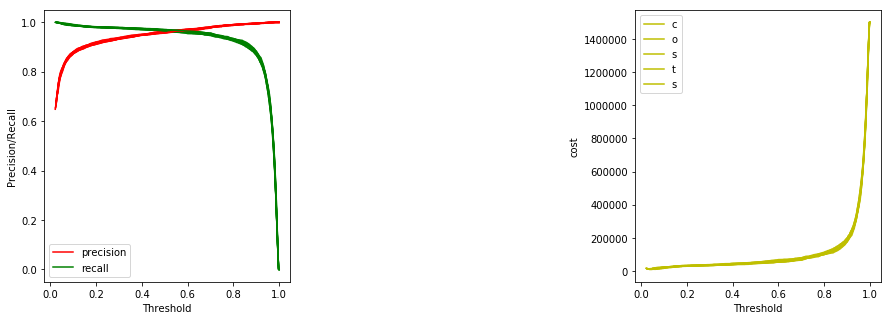

In [60]:
#CV to determine the best threshold
trail = 10
plot = []
for x in range(0,trail):
    train, test, y_tr, y_ts = train_test_split(train_std, y_train, stratify = y_train, train_size = 0.7)
    clf.fit(train,y_tr)
    pred = clf.predict_proba(test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_ts, pred)
    thresholds = np.append(thresholds,1)
      
    costs = []
    for threshold in thresholds:
        y_pred_thres = pred > threshold
        c = confusion_matrix(y_ts,y_pred_thres)
        cost = c[0,1] * 10 + c[1,0] * 500
        costs.append(cost)
        
    plot.append({'threshold': thresholds, 'precision':precision,'recall': recall, 'costs':costs})
    

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for x in plot:
    plt.plot(x['threshold'],x['precision'],'r')
    plt.plot(x['threshold'],x['recall'],'g')
    
plt.legend(('precision','recall'))
plt.xlabel('Threshold')
plt.ylabel("Precision/Recall")

plt.subplot(1,3,3)
for x in plot:
    plt.plot(x['threshold'],x['costs'],'y')
plt.legend(('costs'))
plt.xlabel('Threshold')
plt.ylabel("cost")
plt.show()

- At 0.3, we observe that precision is almost more than 95% and recall is almost around 98%. We want our recall to be near to 100% and at the same time we also want our precision to be high. 

In [62]:
# model fitting and predicting using the best threshold
clf.fit(train_std,y_train)
y_pred_prob = clf.predict_proba(test_std)[:,1]  > 0.30
con_mat =confusion_matrix (y_test, y_pred_prob)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  998
Type 2 error (False Negative) =  3
---------------------------------------------------------------------------------------------------------------------
Total cost =  11480
---------------------------------------------------------------------------------------------------------------------
